<a href="https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/15_PatchTST_a_new_transformer_for_LTSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dwyer's NOTE: this notebook is essentially a perfectly adapted version of the original TSAI_LTSF_tutorial_nb.ipynb
It has no changes to content or intent; it adapts everything to regular timeseries forecasting in addition to  
automating certain configuration settings & it's verified to work on a variety of different Monash Timeseries datasets.

created by Ignacio Oguiza - email: oguiza@timeseriesAI.co

# Purpose 😇

In this notebook, we are going to learn how to use a new state-of-the-art time series transformer called **PatchTST** to create a long-term multivariate time series forecast (LTSF). PatchTST was introduced in the following paper:

* paper: Nie, Y., Nguyen, N. H., Sinthong, P., & Kalagnanam, J. (2022). **A Time Series is Worth 64 Words: Long-term Forecasting with Transformers**. arXiv preprint arXiv:2211.14730.
* arxiv link: https://arxiv.org/abs/2211.14730
* official repository: https://github.com/yuqinie98/PatchTST

The paper will be presented at the **ICLR 2023** Conference later this year. Here's the summary of the paper review by ICLR reviewers:

"The paper applies transformer to long term forecasting problems of multi-dimensional time series. The method is very simple: Take channels independently, break them into patches and predict the patches into the future using the transformer. The main advantage of this paper is that previous papers have applied transformers to this problem but it resulted in a very weak performance, being beaten by a simple linear methods. This paper found a way to apply the transformer successfully, beating the previous methods."

I'd like to thank the authors for publishing this paper, and for making their code available.

Below you can see the results of publised in the paper.

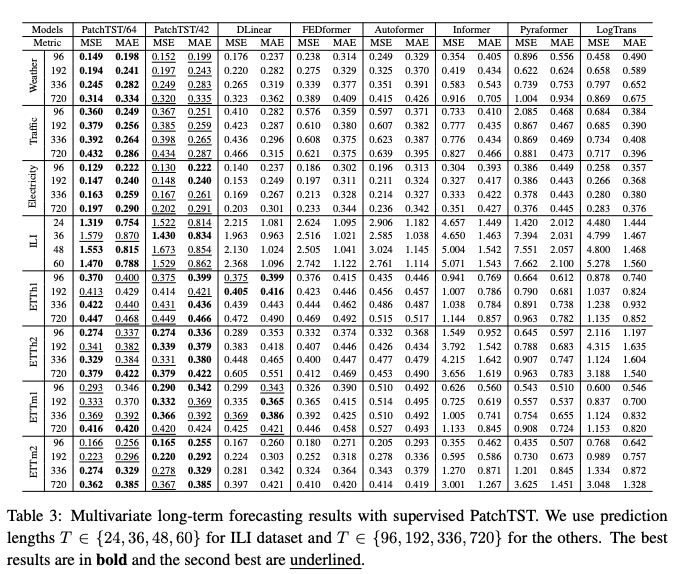

# Install & import libraries 📚

You'll need tsai >= 0.3.5 to be able to run this tutorial.

In [1]:
# # **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
# stable = True # Set to True for latest pip version or False for main branch in GitHub
# !pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

In [2]:
import sklearn
from tsai.basics import *
my_setup(sklearn)

os              : Linux-5.15.0-84-generic-x86_64-with-glibc2.10
python          : 3.8.18
tsai            : 0.3.5
fastai          : 2.7.14
fastcore        : 1.5.29
sklearn         : 1.3.2
torch           : 1.13.1.post200
device          : 1 gpu (['Quadro RTX 5000'])
cpu cores       : 12
threads per cpu : 2
RAM             : 62.48 GB
GPU memory      : [15.74] GB


In [3]:
# seed everything
import random, torch, numpy as np
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [4]:
import tsai.basics as bsc
[item for item in dir(bsc) if item.startswith('get')]

['get_Monash_forecasting_data',
 'get_Monash_regression_data',
 'get_Monash_regression_list',
 'get_UCR_data',
 'get_UCR_multivariate_list',
 'get_UCR_univariate_list',
 'get_annotations_ex',
 'get_arch',
 'get_best_dl_params',
 'get_best_dls_params',
 'get_c',
 'get_cat_cols',
 'get_class',
 'get_classification_data',
 'get_config',
 'get_cont_cols',
 'get_df_usable_idxs',
 'get_dir_size',
 'get_dl_percent_per_epoch',
 'get_empty_df',
 'get_fcst_horizon',
 'get_file_size',
 'get_files',
 'get_first',
 'get_forecasting_list',
 'get_forecasting_splits',
 'get_forecasting_time_series',
 'get_func',
 'get_func_defaults',
 'get_gaps',
 'get_gpu_memory',
 'get_idx_from_df_col_vals',
 'get_idxs',
 'get_idxs_to_keep',
 'get_image_files',
 'get_lds_kernel_window',
 'get_long_term_forecasting_data',
 'get_long_term_forecasting_splits',
 'get_mapping',
 'get_model',
 'get_outliers_IQR',
 'get_percentile',
 'get_plot_fig',
 'get_predefined_splits',
 'get_ram_memory',
 'get_random_states',
 'get_r

# Load and prepare data 🔢

The starting point for this tutorial will be a dataframe that contains our long-term time series data. 

`tsai` allows you to easily download and prepare data from 9 popular datasets, including weather, traffic, electricity, exchange rate, ILI, and four ETT datasets (ETTh1, ETTh2, ETTm1, ETTm2). These datasets have been extensively utilized for long-term time series forecasting benchmarking.

You can download all data from here: https://cloud.tsinghua.edu.cn/d/e1ccfff39ad541908bae/

Here are the statistics of these datasets:

| Datasets | Weather | Traffic | Electricity | Exchange | ILI | ETTh1 | ETTh2 | ETTm1 | ETTm2 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Features | 21 | 862 | 321 | 8 | 7 | 7 | 7 | 7 | 7 |
| Timesteps | 52696 | 17544 | 26304 | 7588 | 966 | 17420 | 17420 | 69680 | 69680 |


## Data preparation steps

There are 5 steps required to prepare data for a forecasting task in `tsai`:

1. Prepare a dataframe with your data, including the variable you want to predict. 
2. Preprocess your data.
3. Define train, valid and test splits.
4. Scale your data using the train split. 
5. Apply a sliding window to prepare your input and output data.

### Prepare dataframe

In this case, we are going to download the dataframe using get_long_term_forecasting_data. You can use any of the following datasets: "ETTh1", "ETTh2", "ETTm1", "ETTm2", "electricity", "exchange_rate", "traffic", "weather", or "ILI".

We are going to use a small dataset called ILI. ILI includes the weekly recorded **influenza-like illness (ILI)** patients data from Centers for
Disease Control and Prevention of the United States between 2002 and 2021, which describes the ratio of patients seen with ILI and the total number of the patients.

The task is a multivariate long-term time series forecasting (LTSF), where multiple variables are predicted simultaneously for multiple time steps.

In [5]:
import random

# NOTE: Monash is the ticket for forecasting! It has 30 different forecasting datasets!
# This is a static list of possible Monash forecasting datasets!
print('All Monash Forecasting Datasets:\n', Monash_forecasting_list)
dsid=random.choice(Monash_forecasting_list)
#dsid="nn5_weekly_dataset" # fixed for now
print(f'Chosen Monash Forecasting Dataset: {dsid}')

df_raw = get_Monash_forecasting_data(dsid)

All Monash Forecasting Datasets:
 ['m1_yearly_dataset', 'm1_quarterly_dataset', 'm1_monthly_dataset', 'm3_yearly_dataset', 'm3_quarterly_dataset', 'm3_monthly_dataset', 'm3_other_dataset', 'm4_yearly_dataset', 'm4_quarterly_dataset', 'm4_monthly_dataset', 'm4_weekly_dataset', 'm4_daily_dataset', 'm4_hourly_dataset', 'tourism_yearly_dataset', 'tourism_quarterly_dataset', 'tourism_monthly_dataset', 'nn5_daily_dataset_with_missing_values', 'nn5_daily_dataset_without_missing_values', 'nn5_weekly_dataset', 'cif_2016_dataset', 'kaggle_web_traffic_dataset_with_missing_values', 'kaggle_web_traffic_dataset_without_missing_values', 'kaggle_web_traffic_weekly_dataset', 'solar_10_minutes_dataset', 'solar_weekly_dataset', 'electricity_hourly_dataset', 'electricity_weekly_dataset', 'london_smart_meters_dataset_with_missing_values', 'london_smart_meters_dataset_without_missing_values', 'wind_farms_minutely_dataset_with_missing_values', 'wind_farms_minutely_dataset_without_missing_values', 'car_parts_

In [6]:
# verified to work 2/7/24
def find_datetime_col(df):
    datetime_col_index = None
    for i in range(len(df.columns)):
        dtype=df.iloc[:, i].dtype
        if 'datetime' in str(dtype):
            print('datetime column:', df.columns[i])
            return df.columns[i]

find_dtype_cols = lambda df, dtypes: list(df.select_dtypes(include=dtypes).columns)

"""
# verified to work 2/8/24
def find_unique_id_cols(df):
    unique_id_cols = find_dtype_cols(df, ['category', 'object'])
    print('unique_id_cols:', unique_id_cols)
    return unique_id_cols
"""

def find_TS_value_cols(df): # instead of df.columns[2:]
    TS_value_cols = find_dtype_cols(df, 'number')
    print('TS_value_cols:', TS_value_cols)
    return TS_value_cols

# verified to work 2/8/24
# NOTE: we need this more complicated approach because data is messy so pd.infer_freq isinconsistent!
def find_freq(df, datetime_col, unique_id_cols):
    if type(unique_id_cols) is str: unique_id_cols=[unique_id_cols]
    all_freqs=df.sort_values(unique_id_cols+[datetime_col]) \
                .groupby(unique_id_cols).apply(lambda group: pd.infer_freq(group[datetime_col]))
    freq=all_freqs.mode().item()
    print('freq:', freq)
    proportion_consistent=(freq==all_freqs).mean()
    print('proportion freqs consistent:', proportion_consistent)
    assert proportion_consistent>0.25, 'Frequencies are inconsistent!'
    return freq

In [7]:
unique_id_cols = 'series_name' # seems to be constant
datetime_col = find_datetime_col(df_raw)
TS_value_cols = find_TS_value_cols(df_raw) # this almost might be constant? But regardless it's helpful to be prepared to multivariate datasets
freq = find_freq(df_raw, datetime_col, unique_id_cols)

datetime column: timestamp
TS_value_cols: ['series_value']
freq: D
proportion freqs consistent: 1.0


In [8]:
print('Example `pd.date_range()` constructed from given timeseries frequency & start datetime:')
pd.date_range(start=df_raw[datetime_col].iloc[0], freq=freq, periods=10)

Example `pd.date_range()` constructed from given timeseries frequency & start datetime:


DatetimeIndex(['2015-05-02 15:00:00', '2015-05-03 15:00:00',
               '2015-05-04 15:00:00', '2015-05-05 15:00:00',
               '2015-05-06 15:00:00', '2015-05-07 15:00:00',
               '2015-05-08 15:00:00', '2015-05-09 15:00:00',
               '2015-05-10 15:00:00', '2015-05-11 15:00:00'],
              dtype='datetime64[ns]', freq='D')

### Proprocess dataframe

`tsai` provides some sklearn-style transforms that can be used to build a preprocessing pipeline. In this case we'll use the following transforms: 

* TSShrinkDataFrame: to save some memory and set the right dtypes.
* TSDropDuplicates: to ensure there are no duplicate timestamps.
* TSAddMissingTimestamps: to fill any missing timestamps. 
* TSFillMissing: to fill any missing data (forward fill, then 0).

All these transforms can be applied to the entire dataset. In other words, they are not dependent on the training set. Other transforms will be applied later, when the training split is available.

You can read about all available transforms in the [docs](https://timeseriesai.github.io/tsai/data.preprocessing.html#sklearn-api-transforms).

In [9]:
unique_id_cols = 'series_name'
datetime_col = find_datetime_col(df_raw)
freq = find_freq(df_raw, datetime_col, unique_id_cols) # Wahoo! It's automatic too!
TS_value_columns = find_TS_value_cols(df_raw)
method = 'ffill'
value = None

print(TS_value_columns)

# NOTE: pipeline is apparently necessary some of the Monash data is messy!
preproc_pipe = sklearn.pipeline.Pipeline([
    ('shrinker', TSShrinkDataFrame()), # shrink dataframe memory usage
    ('drop_duplicates', TSDropDuplicates(datetime_col=datetime_col, unique_id_cols=unique_id_cols)), # drop duplicate rows (if any), WARNING! Extreme df reduction here!
    ('add_mts', TSAddMissingTimestamps(datetime_col=datetime_col, unique_id_cols=unique_id_cols, freq=freq)), # ass missing timestamps (if any) (this is buggy!)
    ('fill_missing', TSFillMissing(columns=TS_value_columns, method=method, value=value)), # fill missing data (1st ffill. 2nd value=0)
    ], verbose=True)
mkdir('data', exist_ok=True, parents=True)
save_object(preproc_pipe, 'data/preproc_pipe.pkl')
preproc_pipe = load_object('data/preproc_pipe.pkl')

df = preproc_pipe.fit_transform(df_raw)
df=df.iloc[:100000]
display(df)

datetime column: timestamp
freq: D
proportion freqs consistent: 1.0
TS_value_cols: ['series_value']
['series_value']
data directory already exists.
Pipeline saved as data/preproc_pipe.pkl
Initial memory usage: 666.50 MB 
Final memory usage  : 378.25 MB  (-43.2%)
[Pipeline] .......... (step 1 of 4) Processing shrinker, total=   2.0s
[Pipeline] ... (step 2 of 4) Processing drop_duplicates, total=   1.0s
[Pipeline] ........... (step 3 of 4) Processing add_mts, total= 1.2min
[Pipeline] ...... (step 4 of 4) Processing fill_missing, total=   0.0s


,timestamp,series_name,station_id,obs_or_fcst,series_value
0,2015-05-02 15:00:00,T0,1006,T_MEAN,24.791670
1,2015-05-03 15:00:00,T0,1006,T_MEAN,25.116671
2,2015-05-04 15:00:00,T0,1006,T_MEAN,26.841669
3,2015-05-05 15:00:00,T0,1006,T_MEAN,27.879169
4,2015-05-06 15:00:00,T0,1006,T_MEAN,28.341669
...,...,...,...,...,...
99995,2017-03-02 15:00:00,T137,1019,fcst_4_DailyPrecip25Pct,11.697200
99996,2017-03-03 15:00:00,T137,1019,fcst_4_DailyPrecip25Pct,16.464800
99997,2017-03-04 15:00:00,T137,1019,fcst_4_DailyPrecip25Pct,14.847200
99998,2017-03-05 15:00:00,T137,1019,fcst_4_DailyPrecip25Pct,25.573000


In [10]:
print('df.isna().any():')
print(df.isna().any())
print('\nlen(df_raw):', len(df_raw))
print('reduced df proportion:', len(df)/len(df_raw))
print('len(unique(series_name)):', len(df_raw['series_name'].unique()))

print('\ndf.dtypes:')
print(df.dtypes)

df.isna().any():
timestamp       False
series_name     False
station_id      False
obs_or_fcst     False
series_value    False
dtype: bool

len(df_raw): 23252200
reduced df proportion: 0.004300668323857527
len(unique(series_name)): 32072

df.dtypes:
timestamp       datetime64[ns]
series_name             object
station_id            category
obs_or_fcst           category
series_value           float32
dtype: object


### Define splits

So we have transformed a multivariate time series with 966 time steps and 7 features (excluding the datetime) into:

* 803 input samples, with 7 features and 104 historical time steps
* 803 input samples, with 7 features and 60 future time steps.

It's very easy to create time forecasting splits in `tsai`. You can use as function called `get_forecasting_splits`:

unique_subset_len: 724
steps in the past: 90
steps in the future: 54


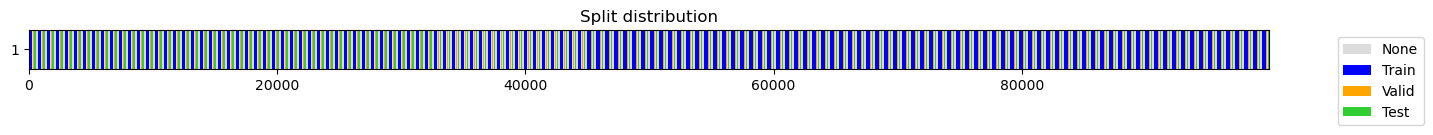

((#41400) [0,1,2,3,4,5,6,7,8,9...],
 (#8142) [353,354,355,356,357,358,359,360,361,362...],
 (#16096) [465,466,467,468,469,470,471,472,473,474...])

In [11]:
# NOTE: reconstruct split distribution graph as seen for LTSF but for arbitrary dataset
unique_subset_len = len(df)//len(df[unique_id_cols].unique()) # need use len of unique subsets
fcst_history = unique_subset_len//8 # steps in the past (based on LTSF, possibly requires adjustment)
fcst_horizon = int(fcst_history*0.6) # steps in the future (based on LTSF, possibly requires adjustment)

print('unique_subset_len:', unique_subset_len)
print('steps in the past:', fcst_history)
print('steps in the future:', fcst_horizon)

valid_size   = 0.1  # int or float indicating the size of the training set
test_size    = 0.2  # int or float indicating the size of the test set

#NOTE: get_long_term_forecasting_splits doesn't make sense here because we have a unique_col_id
splits = get_forecasting_splits(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                unique_id_cols=unique_id_cols, valid_size=valid_size, test_size=test_size, show_plot=True)
splits

### Scale dataframe

Now that we have defined the splits for this particular experiment, we'll scale the data: 

In [12]:
train_split = splits[0]

# pipeline
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=TS_value_columns)), # standardize data using train_split
    ], verbose=True)
save_object(exp_pipe, 'data/exp_pipe.pkl')
exp_pipe = load_object('data/exp_pipe.pkl')

df_scaled = exp_pipe.fit_transform(df, scaler__idxs=train_split)
df_scaled

data directory already exists.
Pipeline saved as data/exp_pipe.pkl
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s


,timestamp,series_name,station_id,obs_or_fcst,series_value
0,2015-05-02 15:00:00,T0,1006,T_MEAN,1.250632
1,2015-05-03 15:00:00,T0,1006,T_MEAN,1.273035
2,2015-05-04 15:00:00,T0,1006,T_MEAN,1.391941
3,2015-05-05 15:00:00,T0,1006,T_MEAN,1.463458
4,2015-05-06 15:00:00,T0,1006,T_MEAN,1.495339
...,...,...,...,...,...
99995,2017-03-02 15:00:00,T137,1019,fcst_4_DailyPrecip25Pct,0.348010
99996,2017-03-03 15:00:00,T137,1019,fcst_4_DailyPrecip25Pct,0.676648
99997,2017-03-04 15:00:00,T137,1019,fcst_4_DailyPrecip25Pct,0.565145
99998,2017-03-05 15:00:00,T137,1019,fcst_4_DailyPrecip25Pct,1.304490


### Apply a sliding window

We'll approach the time series forecasting task as a supervised learning problem. Remember that `tsai` requires that both inputs and outputs have the following shape: 

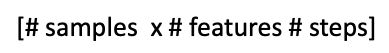

To get those inputs and outputs we're going to use a function called `prepare_forecasting_data` that applies a sliding window along the dataframe:

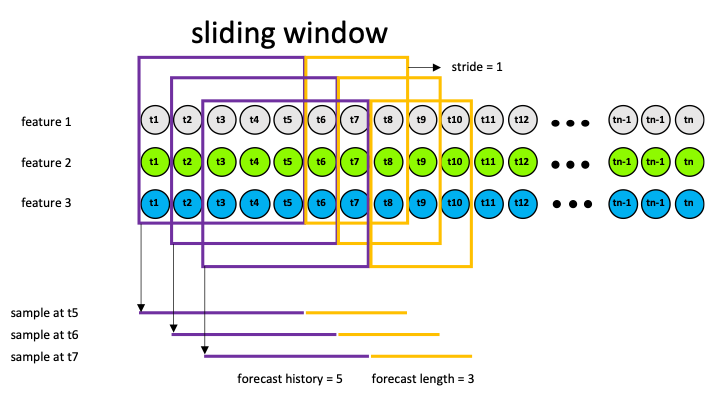

To use `prepare_forecasting_data` we need to define some settings: 

In [13]:
# WTF?? It's the same? Maybe because auto-regression? <-- Yes
x_vars = TS_value_columns
y_vars = TS_value_columns
print('y_vars:', y_vars)
print('x_vars:', x_vars)

y_vars: ['series_value']
x_vars: ['series_value']


In [14]:
# NOTE: they mention this does a sliding window & I also saw there is a TSSlidingWindow (dataset) class
# This makes me think that maybe TSDatasets & similar classes are lower-level & implicitly invoked by these higher level functions!
X, y = prepare_forecasting_data(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
X.shape, y.shape

((99857, 1, 90), (99857, 1, 54))

# Prepare the forecaster 🏋️‍♂️

Now we'll instantiate the forecaster. In `tsai` there's a class called TSForecaster. We are going to use the same settings they used in the paper. 

You can find ILI specific settings here: https://github.com/yuqinie98/PatchTST/blob/main/PatchTST_supervised/scripts/PatchTST/illness.sh

and default model settings here: https://github.com/yuqinie98/PatchTST/blob/main/PatchTST_supervised/run_longExp.py

In [15]:
import torch
# NOTE: This is the full (default) arch_config directly from InceptionTimePlus.__init__() 
# https://timeseriesai.github.io/tsai/models.inceptiontimeplus.html#inceptiontimeplus
arch_config = dict(residual=True, depth=6, coord=False,
                   norm='Batch', zero_norm=False, act=torch.nn.modules.activation.ReLU, act_kwargs={},
                   sa=False, se=None, stoch_depth=1.0, ks=40,
                   bottleneck=True, padding='same', separable=False,
                   dilation=1, stride=1, conv_dropout=0.0, bn_1st=True)
model_arch = "InceptionTimePlus" # default

In [16]:
# GOTCHA: sometimes the notebook will die here, the reason is that it runs OOM with a very large dataset!
# in this case trying running again with another smaller dataset.
learn = TSForecaster(X, y, splits=splits, batch_size=16, path="models", pipelines=[preproc_pipe, exp_pipe],
                     arch=model_arch, arch_config=arch_config, metrics=[mse, mae], cbs=ShowGraph())
# Why do they supply the pipelines again? are they reapplied?

☢️ This is **not good practice**, but all papers using these long-term forecasting datasets have published there data using drop_last=True in the validtion set. You should never use it in your practice. But if you want to try and replicate the results from the paper, you may want to uncomment the following line and set `learn.dls.valid.drop_last=True`. 

In [17]:
learn.dls.valid.drop_last = True

In [18]:
learn.summary()

not enough values to plot a chart


InceptionTimePlus (Input shape: 16 x 1 x 90)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 32 x 90        
Conv1d                                    32         True      
Conv1d                                    39936      True      
Conv1d                                    19456      True      
Conv1d                                    9216       True      
MaxPool1d                                                      
____________________________________________________________________________
                     16 x 32 x 90        
Conv1d                                    32         True      
____________________________________________________________________________
                     16 x 128 x 90       
Concat                                                         
BatchNorm1d                               256        True      
ReLU                                                           
___________________________________

As you can see this is a very small model, with only 57k parameters!

# Train model 🏃🏿‍♂️

In this case we'll use the same number of epochs and learning rate they used in the paper. 

⚠️ Whenever you need to look for a good learning rate to train a model you can use:
```python
lr_max = learn.lr_find().valley
```

epoch,train_loss,valid_loss,mse,mae,time
0,0.208908,0.246528,0.246528,0.239292,01:21


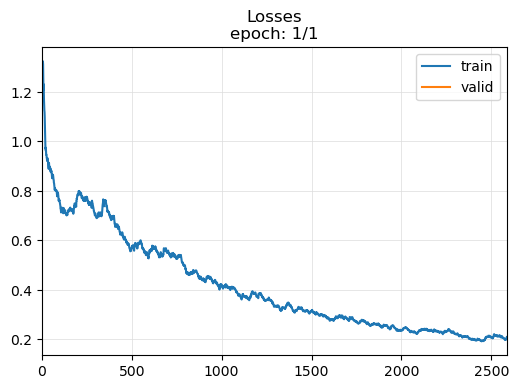

not enough values to plot a chart


In [19]:
learn = TSForecaster(X, y, splits=splits, batch_size=16, path="models", pipelines=[preproc_pipe, exp_pipe],
                     arch=model_arch, arch_config=arch_config, metrics=[mse, mae], cbs=[ShowGraph()])

n_epochs = 1
lr_max = 0.0025
learn.fit_one_cycle(n_epochs, lr_max=lr_max)
learn.export(f'{model_arch}.pt')

# Evaluate model 🕵️‍♀️

## Valid split

First we are going to check that the valid predictions match the results we got during training. But you can skip this step since it's not required.

In [20]:
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error

learn = load_learner(f'models/{model_arch}.pt')
scaled_preds, *_ = learn.get_X_preds(X[splits[1]])
scaled_preds = to_np(scaled_preds)
print(f"scaled_preds.shape: {scaled_preds.shape}")

scaled_y_true = y[splits[1]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["valid", "mse"] = mean_squared_error(scaled_y_true.flatten(), scaled_preds.flatten())
results_df.loc["valid", "mae"] = mean_absolute_error(scaled_y_true.flatten(), scaled_preds.flatten())
results_df

scaled_preds.shape: (8142, 1, 54)


,mse,mae
valid,0.246529,0.239292


## Test split

So now we'll use the test split to measure performance (this is the one you that is published in the paper). 

⚠️ You may find some differences due to randomness of the process. In addition to that, the authors used a test dataloader that drop the last batch if incomplete, which means that not all samples are used to measure performance. In `tsai` we are using all samples.

In [21]:
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error

learn = load_learner(f'models/{model_arch}.pt')
y_test_preds, *_ = learn.get_X_preds(X[splits[2]])
y_test_preds = to_np(y_test_preds)
print(f"y_test_preds.shape: {y_test_preds.shape}")

y_test = y[splits[2]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["test", "mse"] = mean_squared_error(y_test.flatten(), y_test_preds.flatten())
results_df.loc["test", "mae"] = mean_absolute_error(y_test.flatten(), y_test_preds.flatten())
results_df

y_test_preds.shape: (16096, 1, 54)


,mse,mae
test,1.963455,0.957556


### Visualize predictions

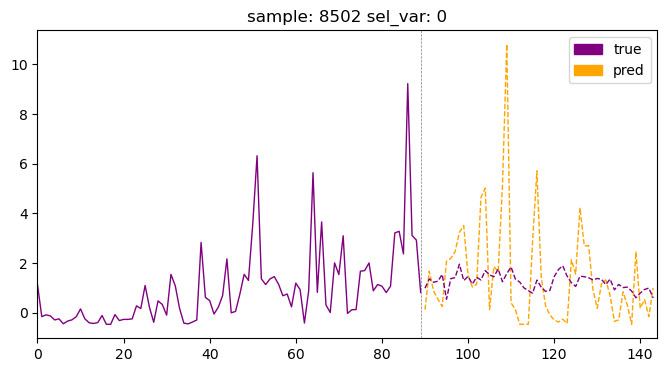

In [22]:
X_test = X[splits[2]]
y_test = y[splits[2]]
plot_forecast(X_test, y_test, y_test_preds, sel_vars=True)

# Inference 🚀 

## Prepare dataframe

If you want to use the model with new data, you'll need to first prepare the data following the process we defined before. 

Let's assume we want to create a prediction for '2020-06-30'. In our case, we need a history of 104 time steps to predict the next 60 days. We'll prepare data in the following way: 

In [23]:
import random

# choose some arbitrary date to make a forecast for
fcst_date = random.choice(df[datetime_col].dt.date)
print(f'making a forecast for date: {fcst_date}')

dates = pd.date_range(start=None, end=fcst_date, periods=fcst_history, freq=freq)
dates

making a forecast for date: 2015-12-19


DatetimeIndex(['2015-09-21', '2015-09-22', '2015-09-23', '2015-09-24',
               '2015-09-25', '2015-09-26', '2015-09-27', '2015-09-28',
               '2015-09-29', '2015-09-30', '2015-10-01', '2015-10-02',
               '2015-10-03', '2015-10-04', '2015-10-05', '2015-10-06',
               '2015-10-07', '2015-10-08', '2015-10-09', '2015-10-10',
               '2015-10-11', '2015-10-12', '2015-10-13', '2015-10-14',
               '2015-10-15', '2015-10-16', '2015-10-17', '2015-10-18',
               '2015-10-19', '2015-10-20', '2015-10-21', '2015-10-22',
               '2015-10-23', '2015-10-24', '2015-10-25', '2015-10-26',
               '2015-10-27', '2015-10-28', '2015-10-29', '2015-10-30',
               '2015-10-31', '2015-11-01', '2015-11-02', '2015-11-03',
               '2015-11-04', '2015-11-05', '2015-11-06', '2015-11-07',
               '2015-11-08', '2015-11-09', '2015-11-10', '2015-11-11',
               '2015-11-12', '2015-11-13', '2015-11-14', '2015-11-15',
      

In [24]:
new_df = get_Monash_forecasting_data(dsid)
new_df

Dataset: temperature_rain_dataset_with_missing_values
converting data to dataframe...
...done

freq                   : daily
forecast_horizon       : 30
contain_missing_values : True
contain_equal_length   : True

exploding dataframe...
...done


data.shape: (23252200, 5)


,series_name,station_id,obs_or_fcst,timestamp,series_value
0,T0,1006,T_MEAN,2015-05-02 15:00:00,24.791670
1,T0,1006,T_MEAN,2015-05-03 15:00:00,25.116671
2,T0,1006,T_MEAN,2015-05-04 15:00:00,26.841669
3,T0,1006,T_MEAN,2015-05-05 15:00:00,27.879169
4,T0,1006,T_MEAN,2015-05-06 15:00:00,28.341669
...,...,...,...,...,...
23252195,T32071,200786,fcst_5_DailyPrecip75Pct,2017-04-21 15:00:00,0.000000
23252196,T32071,200786,fcst_5_DailyPrecip75Pct,2017-04-22 15:00:00,0.000000
23252197,T32071,200786,fcst_5_DailyPrecip75Pct,2017-04-23 15:00:00,0.000000
23252198,T32071,200786,fcst_5_DailyPrecip75Pct,2017-04-24 15:00:00,0.000000


In [25]:
new_df[datetime_col].isin(dates).sum()/len(dates)

0.0

In [26]:
new_df = new_df[new_df[datetime_col].isin(dates)].reset_index(drop=True)
assert len(new_df)>0
new_df

AssertionError: 

## Preprocess dataframe

In [ ]:
from tsai.inference import load_learner

learn = load_learner(f'models/{model_arch}.pt')
new_df = learn.transform(new_df) # transform?
new_df

## Apply sliding window

In [ ]:
x_feat = find_TS_value_cols(new_df)
new_X, _ = prepare_forecasting_data(new_df, fcst_history=fcst_history, fcst_horizon=0, x_vars=x_feat, y_vars=None)
new_X.shape

In [ ]:
print(new_df.columns)

## Cast predictions

In [ ]:
new_scaled_preds, *_ = learn.get_X_preds(new_X)

new_scaled_preds = to_np(new_scaled_preds).swapaxes(1,2).reshape(-1, len(y_vars))
dates = pd.date_range(start=fcst_date, periods=fcst_horizon + 1, freq=freq)[1:]
preds_df = pd.DataFrame(dates, columns=[datetime_col])
preds_df.loc[:, y_vars] = new_scaled_preds
preds_df = learn.inverse_transform(preds_df)
preds_df

# Conclusion ✅

In this notebook we have covered the following topics:

* PatchTST: a new state-of-the-art transformer for long-term multivariate time series forecasting.
* how to prepare data for a time series task.
* how to use PatchTST within the tsai framework.
* how to use predict multiple variables and multiple steps into the future.
* how to visualize predictions and compare them to true values.

I hope you've found this helpful. Now it's your opportunity to start creating your own forecasts!